For the sake of safety in case of one of us making a dumb mistake we elected to make two seperate codebasees to solve this, the other is the primary one and this is the alternative, altough there are still situations in wich the graphs from this code are used

This is for the first extension of the problem

In [1]:
from scipy.optimize import linprog
import numpy as np
import pandas as pd
import cvxpy as cp
import time
import gurobipy
import seaborn
import gurobipy
from pyDOE import lhs


This generates a problem wich is the deterministic equivalent of  the previous subproblem but with the second phase being nreal realisations of alpha

In [13]:
nreal = 10
#we just take the all scenario set for these and then varry the supply limitations
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
cinstall =[10.,7.,16.,6.]   #costs for instalation
#costs
costsvec= [v*i*p/nreal for p in probs for v in [10,6,1]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage
cset = cinstall+costsvec*nreal

randvals= np.random.uniform(size=nreal*4)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
randvals = [randvals[x*4+k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)]
x=cp.Variable(len(cset) )


#phase 1 constraints
#budget
constr = [x>=0]
constr = constr+[x[0:4]@cinstall<=120 ]

#energy requirement constraint
#not a hard constraint anymore but still sensible to have some version of it
constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

#phase 2 constaints
#energy supply
base= np.array([0,1,2,3,4]) 
multidin2 = np.array([1,1,1,1,1])
constr = constr + [-x[base+k*5+4]@multidin2<= demands[(k//3)%27][k%3] for k in range(nreal*27*3)]
print([0,1,2,3,4][0:4])
print(len(cset))
print(constr[-1])
#capacity
base= np.array([4,9,14]) 
multiding = np.array([1,1,1])
constr = constr + [x[k]*randvals[(v//27)*4+k]-x[base+k+v*15]@multiding>=0.  for v in range(27*nreal) for k in range(4)]
print(constr[-1])


[0, 1, 2, 3]
4054
-var270094[4049 4050 4051 4052 4053] @ [1. 1. 1. 1. 1.] <= -3.0
0.0 <= var270094[3] @ 0.984595613113094 + -var270094[4042 4047 4052] @ [1. 1. 1.]


In [14]:
cset = np.array(cset)
problem = cp.Problem(cp.Minimize(cset.T @x),constr )
t1 = time.time()
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res= problem.solve(verbose = True, QCPDual = 1, solver  = cp.GUROBI, env=env)

    
t2 = time.time()
print(x.value)
#cost
print(problem.value)  
print( problem.variables())
#time to run
print(t2-t1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558038


Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Set parameter TimeLimit to value 100
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 05 08:40:44 PM: Your problem has 4054 variables, 5946 constraints, and 0 parameters.
(CVXPY) Oct 05 08:40:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 05 08:40:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 05 08:40:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 05 08:40:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
------------------

In [15]:
print(x.value[0:4])
print(x.value[0:4]@[0.9,0.8,0.8,1.])
print(x.value[0:4]@cinstall)
print(problem)

[4.49903973 6.61353799 0.         1.82330739]
11.163273544528108
102.22500761510561
minimize [1.000e+01 7.000e+00 1.600e+01 ... 8.640e-03 1.485e-02 2.700e-02] @ var270094
subject to 0.0 <= var270094
           var270094[0:4] @ [10.  7. 16.  6.] <= 120.0
           5.0 <= var270094[0:4] @ [0.9 0.8 0.8 1. ]
           -var270094[4 5 6 7 8] @ [1. 1. 1. 1. 1.] <= -3.0
           -var270094[ 9 10 11 12 13] @ [1. 1. 1. 1. 1.] <= -2.0
           -var270094[14 15 16 17 18] @ [1. 1. 1. 1. 1.] <= -1.0
           -var270094[19 20 21 22 23] @ [1. 1. 1. 1. 1.] <= -5.0
           -var270094[24 25 26 27 28] @ [1. 1. 1. 1. 1.] <= -2.0
           -var270094[29 30 31 32 33] @ [1. 1. 1. 1. 1.] <= -1.0
           -var270094[34 35 36 37 38] @ [1. 1. 1. 1. 1.] <= -7.0
           -var270094[39 40 41 42 43] @ [1. 1. 1. 1. 1.] <= -2.0
           -var270094[44 45 46 47 48] @ [1. 1. 1. 1. 1.] <= -1.0
           -var270094[49 50 51 52 53] @ [1. 1. 1. 1. 1.] <= -3.0
           -var270094[54 55 56 57 58] @ [1. 1. 1

This also generates a problem with nreal realisations of the second phase with different values of alpha, however, this specifies alpha as a parameter

In [87]:
nreal = 40
#we just take the all scenario set for these and then varry the supply limitations
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
cinstall =[10.,7.,16.,6.]   #costs for instalation
#costs
costsvec= [v*i*p/nreal for p in probs for v in [10,6,1]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage
cset = cinstall+costsvec*nreal

randvals= np.random.uniform(size=nreal*4)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
randvals = cp.Parameter(shape=nreal*4 ,value= [randvals[x*4+k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)])
x=cp.Variable(len(cset) )


#phase 1 constraints
#budget
constr = [x>=0]
constr = constr+[x[0:4]@cinstall<=120 ]

#energy requirement constraint
#not a hard constraint anymore but still sensible to have some version of it
#constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

#phase 2 constaints
#energy supply
base= np.array([0,1,2,3,4]) 
multidin2 = np.array([1,1,1,1,1])
constr = constr + [-x[base+k*5+4]@multidin2<= demands[(k//3)%27][k%3] for k in range(nreal*27*3)]
print([0,1,2,3,4][0:4])
print(len(cset))
print(constr[-1])
#capacity
base= np.array([4,9,14]) 
multiding = np.array([1,1,1])
constr = constr + [x[k]*randvals[(v//27)*4+k]-x[base+k+v*15]@multiding>=0.  for v in range(27*nreal) for k in range(4)]
print(constr[-1])

[0, 1, 2, 3]
16204
-var96317016[16199 16200 16201 16202 16203] @ [1. 1. 1. 1. 1.] <= -3.0
0.0 <= var96317016[3] @ param96317015[159] + -var96317016[16192 16197 16202] @ [1. 1. 1.]


here we solve the problem once to compile it

In [88]:
cset = np.array(cset)
problem = cp.Problem(cp.Minimize(cset.T @x),constr )
t1 = time.time()
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res= problem.solve(verbose = True, QCPDual = 1, solver  = cp.GUROBI, env=env)

    
t2 = time.time()
print(x.value)
#cost
print(problem.value)  
print( problem.variables())
print(t2-t1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558038
Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Set parameter TimeLimit to value 100
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 21 07:57:35 PM: Your problem has 16204 variables, 23765 constraints, and 160 parameters.
(CVXPY) Oct 21 07:57:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 21 07:57:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 21 07:57:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------

Here we solve the problem once as a sanity check

In [89]:

rndvl= np.random.uniform(size=nreal*4)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
randvals.value = [rndvl[x*4+k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)]
res= problem.solve( QCPDual = 1, solver  = cp.GUROBI, env=env)
#first phase paarameters
print(x.value[0:4])
#cost
print(problem.value)
#best case scenario power yield
print(x.value[0:4]@[0.9,0.8,0.8,1.])
#first phase costs
print(x.value[0:4]@cinstall)

[6.34735044 4.46008023 0.         1.70971883]
409.2795224533147
10.99039840835793
104.95237897227729


This solves the problem for many sets of LHS distributed sets of realisations of alpha. we store these results for later usage

In [102]:
params =[]
values = []

for o in range(150):
    print(o)
    rands = lhs(4,nreal)
    randvals.value = [rands[x][k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)]
    res= problem.solve( QCPDual = 1, solver  = cp.GUROBI, env=env)
    values = values + [problem.value]
    params = params + [x.value[0:4]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


Here we make the plots of parameter distribution and cost distribution

[410.7829982093067, 410.8285000525678, 411.01258627041983, 410.9271493335441, 410.94908698477957, 411.0191937607366, 410.83632890535966, 410.9634917134387, 410.9239185734718, 410.8680749891938, 410.9489500880343, 410.87233765596574, 410.927966025761, 410.8900691065936, 410.80870248595943, 410.8279345731231, 411.0292036880198, 410.91295012293835, 410.9391792315676, 410.7622798719634, 410.84649803043817, 410.90376801803916, 410.7738126101838, 410.8729380954089, 410.8762854601101, 410.9526651227721, 410.8300742718548, 410.8573771560573, 410.82887692860555, 410.943088449508, 410.8415454762062, 410.8300427008973, 410.80056857265583, 410.9963398737836, 410.82623997364533, 410.9976991312986, 410.8150185614635, 410.82200515047947, 410.95218019220175, 410.9189297891327, 410.7639904953926, 410.8307510492993, 410.87183212656385, 410.85060818300497, 410.9138810963646, 410.7947551523192, 410.8105987458897, 410.82727437639363, 410.9780480135788, 410.95663166665986, 410.911315101271, 410.784238220826

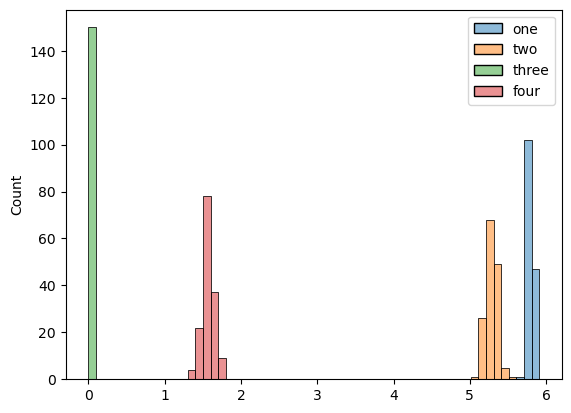

In [106]:
import seaborn
import pandas
import seaborn.objects
print(values)
print(params)
valueframe = pandas.DataFrame(values, columns=["cost"])
thing1 = seaborn.objects.Plot(valueframe, x="cost").add( seaborn.objects.Bars(),seaborn.objects.Hist())
#thing1=seaborn.histplot(valueframe, x="cost")
thing1.save("plot1 in sample costs 150 tests 40 sample size each")
print(min(values)==max(values))
print()
thing1
paramar = pandas.DataFrame(params,columns=["one","two","three","four"])

print(max(paramar["three"]))
thign2=seaborn.histplot(paramar,binwidth=0.1)
thign2.get_figure().savefig("plot2 first phase results 150 tests 40 sample size each")
#thing2 = seaborn.objects.Plot(paramar, x=["one","two","three","four"]).add( seaborn.objects.Bars(),seaborn.objects.Hist())
#thing2.save("plot2 first phase results 150 tests 40 sample size each")

This is the same problem but with the first phase paramaters set as parameters, so we can test out of sample performance of these sollutions

In [8]:
cases = 1
#we just take the all scenario set for these and then varry the supply limitations
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
cinstall =[10.,7.,16.,6.]   #costs for instalation
#costs
costsvec= [v*i*p/cases for p in probs for v in [10,6,1]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage
cset = costsvec*cases

rqual= np.random.uniform(size=cases*4)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
rqual = cp.Parameter(shape=cases*4 ,value=[rqual[x*4+k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)])

#randvals = [randvals[x*4+k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)]
x=cp.Variable(len(cset) )
capacities= cp.Parameter(shape=4, value=[10]*4)

#phase 1 constraints
#budget
constr = [x>=0]
#constr = constr+[x[0:4]@cinstall<=120 ]

#energy requirement constraint
#not a hard constraint anymore but still sensible to have some version of it
#constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

#phase 2 constaints
#energy supply
base= np.array([0,1,2,3,4]) 
multidin2 = np.array([1,1,1,1,1])
constr = constr + [-x[base+k*5]@multidin2<= demands[(k//3)%27][k%3] for k in range(cases*27*3)]
print([0,1,2,3,4][0:4])
print(len(cset))
print(constr[-1])
#capacity
base= np.array([0,5,10]) 
multiding = np.array([1,1,1])
constr = constr + [capacities[k]*rqual[(v//27)*4+k]-x[base+k+v*15]@multiding>=0.  for v in range(27*cases) for k in range(4)]
print(constr[-1])

[0, 1, 2, 3]
405
-var2[400 401 402 403 404] @ [1. 1. 1. 1. 1.] <= -3.0
0.0 <= param3[3] @ param1[3] + -var2[393 398 403] @ [1. 1. 1.]


compile it

In [9]:
cset = np.array(cset)
lilproblem = cp.Problem(cp.Minimize(cset.T @x),constr )
t1 = time.time()
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res= lilproblem.solve( QCPDual = 1, solver  = cp.GUROBI, env=env)

    
t2 = time.time()
print(x.value)
print(lilproblem.value)  
print( lilproblem.variables())
print(t2-t1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558038
Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Set parameter TimeLimit to value 100


e:\optim uncertain\.conda\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:237: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[0.         0.         3.         0.         0.         0.
 0.         2.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         5.
 0.         0.         0.         0.         2.         0.
 0.         0.40659311 0.         0.59340689 0.         0.
 0.         0.         7.         0.         0.         1.40659311
 0.         0.59340689 0.         0.         1.         0.
 0.         0.         0.         0.         0.         3.
 0.         0.         0.         0.         3.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         5.         0.         0.         0.40659311
 0.         2.59340689 0.         0.         1.         0.
 0.         0.         0.         0.         0.         7.
 0.         0.         2.40659311 0.         0.59340689 0.
 0.         1.         0.         0.         0.         0.
 0.         0.         3.         0.         0.         0.
 0.         4.         0.         0.    

We test here 150 out of sample cases, takes forever but it ensures consistency, general outcome, it's all decently consistent.

In [12]:
np.random.seed = 24567
ntests=150
rndvl= lhs(4,ntests)
rndvl = [[rndvl[x+t][k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)] for t in range(ntests)]
print(rndvl)
valuevector = []
for Val in range(len(params)):
    print(Val)
    capacities.value = params[Val]
    curval =params[Val]@[10.,7.,16.,6.]
    for t in rndvl:
        rqual.value = t
        lilproblem.solve(QCPDual = 1, solver  = cp.GUROBI, env=env )
        curval = curval +lilproblem.value/ntests
    valuevector = valuevector +[curval]

[[0.6738869987648773, 0.7339845231839931, 0.6259915909043482, 0.9821648626972113], [0.6218977316685246, 0.7741998384798705, 0.7344310470147762, 0.9272139208321956], [0.7967202941899816, 0.7896383474295882, 0.50471923208751, 0.9045291730202346], [0.7912895557605255, 0.7571367762097174, 0.6226130499496875, 0.9116768809057376], [0.635262404874296, 0.7547933333011336, 0.6831096834550889, 0.937600087607823], [0.6956410588673464, 0.7443339193321, 0.5941179183161356, 0.9448106348701432], [0.6987613603899606, 0.7168578786704013, 0.6953044337410649, 0.9029201131221156], [0.8766768396359386, 0.7883891246315843, 0.6532384022354423, 0.9409210600059581], [0.7490874199890298, 0.748110791603193, 0.5016347817197383, 0.9849684337815505], [0.6035491115862365, 0.7858583666098016, 0.728832207368785, 0.941557064560825], [0.80886878756578, 0.7348387576946543, 0.7780904180567765, 0.9793696379289353], [0.8496174485429597, 0.735622297667637, 0.5400796012200393, 0.9609382570856877], [0.6174935540715978, 0.76004

Graphing these results

[5.78769532 5.25560455 0.         1.62023686]
410.8611467879727
104.38760627264338


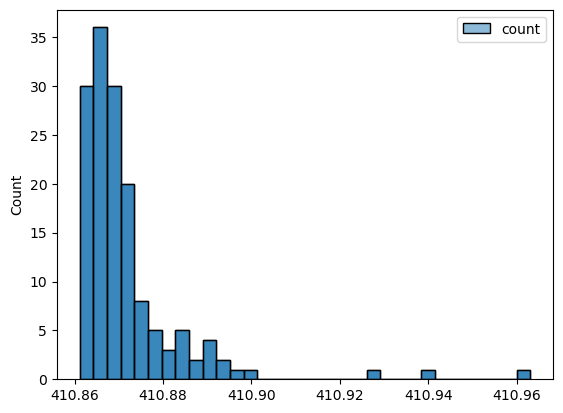

In [15]:
import pandas
seaborn.histplot(valuevector)
valuevectorpd = pandas.DataFrame(valuevector, columns=["count"])
valuevectorpd.to_csv("out of sample cost with 200 trials of 150 cases of 40 iteration first phase parameters")
seaborn.histplot(valuevectorpd).get_figure().savefig("plot3 out of sample cost with 150 trials of 150 cases of 40 iteration first phase parameters")

print(params[ valuevector.index(min(valuevector))])
optipars = params[ valuevector.index(min(valuevector))]
print(min(valuevector))
print(sum( [params[ valuevector.index(min(valuevector))][k]*[10.,7.,16.,6.][k] for k in range(4)]))

Getting a more formal idea of model performance

In [16]:
print(min(valuevectorpd["count"]))
minvaluevec = valuevectorpd["count"]-min(valuevectorpd["count"])
print(1/np.mean(minvaluevec))


410.8611467879727
95.4473240818777


We test out of sample performance again for the previous found optimal to avoid selection bias

In [19]:
np.random.seed = 245678
ntests=2000
rndvl= lhs(4,ntests)
#np.random.uniform(size=cases*4*ntests)
rndvl = [[rndvl[x+t][k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)] for t in range(ntests)]
print(rndvl)
valuevector4 = []
capacities.value = optipars
curval =optipars@[10.,7.,16.,6.]
for t in rndvl:
    rqual.value = t
    lilproblem.solve(QCPDual = 1, solver  = cp.GUROBI, env=env )
    
    valuevector4.append(curval+lilproblem.value)

[[0.8727325517988991, 0.7702417071164289, 0.7689053870183339, 0.971765387560849], [0.8702532612835436, 0.7678900922849368, 0.5769513246535269, 0.9957879961637656], [0.8268859752103838, 0.752391888069906, 0.6733325200369007, 0.9758391669923479], [0.6498819239504208, 0.729889547907587, 0.6899490150253134, 0.9660322193747135], [0.8904441840102677, 0.700348307380677, 0.5859670430252831, 0.9028333023778741], [0.7575855895774091, 0.7594762338072105, 0.7418681734816587, 0.9371438847113868], [0.8586334200019177, 0.7720126880880932, 0.5328202656393056, 0.9567823717164606], [0.8939260044994142, 0.7145524272345054, 0.5679154246818774, 0.9188311363314307], [0.67428776844825, 0.7984388577582038, 0.766220644005815, 0.9534486642548765], [0.6824907585602781, 0.7987019165416541, 0.6200046280455498, 0.9819501792477221], [0.6733466181366171, 0.7918169499814605, 0.56340114928678, 0.9259042443692436], [0.6556267706477731, 0.709836599902148, 0.6408515196489829, 0.9246911228818623], [0.7322472579159067, 0.78

Here we plot and summarise the performance figures for this sollution

410.8796501308679
7.044428326863142


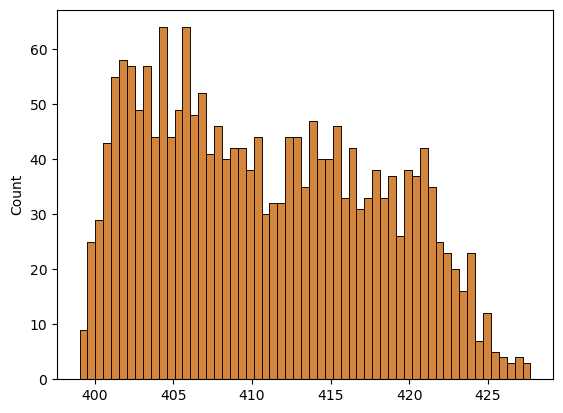

In [20]:
seaborn.histplot(valuevector4, binwidth=0.5).get_figure().savefig("plot 4, out of sample costs for optimal result, 2000 cases")
seaborn.histplot(valuevector4, binwidth=0.5)

print(np.mean(valuevector4))
print(np.std(valuevector4))

We formulate here the expected value scenario for only alpha

In [3]:
nreal = 1
#we just take the all scenario set for these and then varry the supply limitations
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
cinstall =[10.,7.,16.,6.]   #costs for instalation
#costs
costsvec= [v*i*p/nreal for p in probs for v in [10,6,1]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage
cset = cinstall+costsvec*nreal

randvals= [0.5]*4
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
randvals = [randvals[x*4+k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)]
x=cp.Variable(len(cset) )


#phase 1 constraints
#budget
constr = [x>=0]
constr = constr+[x[0:4]@cinstall<=120 ]

#energy requirement constraint
#not a hard constraint anymore but still sensible to have some version of it
#constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

#phase 2 constaints
#energy supply
base= np.array([0,1,2,3,4]) 
multidin2 = np.array([1,1,1,1,1])
constr = constr + [-x[base+k*5+4]@multidin2<= demands[(k//3)%27][k%3] for k in range(nreal*27*3)]
print([0,1,2,3,4][0:4])
print(len(cset))
print(constr[-1])
#capacity
base= np.array([4,9,14]) 
multiding = np.array([1,1,1])
constr = constr + [x[k]*randvals[(v//27)*4+k]-x[base+k+v*15]@multiding>=0.  for v in range(27*nreal) for k in range(4)]
print(constr[-1])

[0, 1, 2, 3]
409
-var1[404 405 406 407 408] @ [1. 1. 1. 1. 1.] <= -3.0
0.0 <= var1[3] @ 0.9500000000000001 + -var1[397 402 407] @ [1. 1. 1.]


Here we solve the expected value scenario and obtain some summary statistics

In [4]:
cset = np.array(cset)
lilproblem = cp.Problem(cp.Minimize(cset.T @x),constr )
t1 = time.time()
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res= lilproblem.solve( QCPDual = 1, solver  = cp.GUROBI, env=env)

    
t2 = time.time()
print(x.value)
print(lilproblem.value)  
print( lilproblem.variables())
print(t2-t1)
avph11= x.value[0:4]
print(avph11)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558038
Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Set parameter TimeLimit to value 100
[6.66666667 4.         0.         2.10526316 3.         0.
 0.         0.         0.         2.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         5.         0.         0.         0.         0.
 0.         2.         0.         0.         0.         0.
 1.         0.         0.         0.         5.         2.
 0.         0.         0.         0.         1.         0.
 1.         0.         0.         0.         0.         1.
 0.         3.         0.         0.         0.         0.
 2.         1.         0.         0.         0.         0.
 1.         0.         0.         0.         5.         0.
 0.         0.         0.         0.         3.         0.
 0.         0.         0.         0.         0.         1.
 0.         5

This is the same rough code as used before to evaluate the in use performance of sample generated first phase paramters but with these first phase parameters hardcoded to be the expected value scenario, this speeds up performance

In [7]:
cases = 1
#we just take the all scenario set for these and then varry the supply limitations
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
cinstall =[10.,7.,16.,6.]   #costs for instalation
#costs
costsvec= [v*i*p/cases for p in probs for v in [10,6,1]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage
cset = costsvec*cases

rqual= np.random.uniform(size=cases*4)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
rqual = cp.Parameter(shape=cases*4 ,value=[rqual[x*4+k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)])

#randvals = [randvals[x*4+k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)]
x=cp.Variable(len(cset) )
#capacities = [6.66,4,0,0]
capacities= avph11

#phase 1 constraints
#budget
constr = [x>=0]
#constr = constr+[x[0:4]@cinstall<=120 ]

#energy requirement constraint
#not a hard constraint anymore but still sensible to have some version of it
#constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

#phase 2 constaints
#energy supply
base= np.array([0,1,2,3,4]) 
multidin2 = np.array([1,1,1,1,1])
constr = constr + [-x[base+k*5]@multidin2<= demands[(k//3)%27][k%3] for k in range(cases*27*3)]
print([0,1,2,3,4][0:4])
print(len(cset))
print(constr[-1])
#capacity
base= np.array([0,5,10]) 
multiding = np.array([1,1,1])
constr = constr + [capacities[k]*rqual[(v//27)*4+k]-x[base+k+v*15]@multiding>=0.  for v in range(27*cases) for k in range(4)]
print(constr[-1])

[0, 1, 2, 3]
405
-var5738[400 401 402 403 404] @ [1. 1. 1. 1. 1.] <= -3.0
0.0 <= 2.1052631578947367 @ param5737[3] + -var5738[393 398 403] @ [1. 1. 1.]


compile the problem and test speed

In [8]:
cset = np.array(cset)
lilproblem = cp.Problem(cp.Minimize(cset.T @x),constr )
t1 = time.time()
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res= lilproblem.solve( QCPDual = 1, solver  = cp.GUROBI, env=env)

    
t2 = time.time()
print(x.value)
print(lilproblem.value)  
print( lilproblem.variables())
print(t2-t1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558038
Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Set parameter TimeLimit to value 100
[3.         0.         0.         0.         0.         1.43089442
 0.56910558 0.         0.         0.         0.         1.
 0.         0.         0.         4.43089442 0.56910558 0.
 0.         0.         0.         2.         0.         0.
 0.         0.         0.53606649 0.         0.46393351 0.
 4.43089442 2.56910558 0.         0.         0.         0.
 0.53606649 0.         1.46393351 0.         0.         0.
 0.         0.61910671 0.38089329 3.         0.         0.
 0.         0.         1.43089442 1.56910558 0.         0.
 0.         0.         1.         0.         0.         0.
 4.43089442 0.56910558 0.         0.         0.         0.
 2.53606649 0.         0.46393351 0.         0.         0.
 0.         1.         0.         4.43089442 2.56910558 0.
 0.  

as it is quite fast we can run these evaluations for a larger sample quite easily

In [11]:
np.random.seed = 654821
ntests=8000
rndvl= lhs(4,ntests)
rndvl = [[rndvl[x+t][k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)] for t in range(ntests)]

#rndvl= np.random.uniform(size=cases*4*ntests)
#rndvl = [[rndvl[x*4+k+t*cases*4]*adds[k]+mins[k]  for x in range(cases) for k in range(4)] for t in range(ntests)]
print(rndvl)
Vtestvec = []
#curval =sum([optipars[i]*[10.,7.,16.,6.][i] for i in range(4)]) 
curval =avph11@[10.,7.,16.,6.]
print(curval)
q = 0
for t in rndvl:
    print(q)
    rqual.value = t
    lilproblem.solve( solver  = cp.GUROBI, env=env )
    Vtestvec =Vtestvec+[curval +lilproblem.value] 
    q=q+1
print(np.mean(Vtestvec))
print(np.sqrt(np.var(Vtestvec)))

[[0.7405744509427336, 0.7840575010224083, 0.593045098544554, 0.9440823176066159], [0.6737959342233145, 0.7236624586066356, 0.6129552058627284, 0.9563683588145099], [0.6957695209437759, 0.7667016673964293, 0.7134400901298767, 0.9311665827758281], [0.6176689107836483, 0.7263793279971084, 0.6424915118726134, 0.9710237140159755], [0.7063030259414124, 0.7205208169758819, 0.5062618104827298, 0.9025758523433313], [0.8733894729328051, 0.7712045416365618, 0.6362393917862139, 0.9400140537942844], [0.760243071483326, 0.753016525178154, 0.5800248717730493, 0.9430746238928944], [0.6934799037466975, 0.769248095198354, 0.6721461479918123, 0.9798175659248384], [0.7912594143215396, 0.7023051414887942, 0.5062003833648694, 0.987142406480882], [0.6026436682555225, 0.766822229656359, 0.6601457806402081, 0.9128508120669477], [0.6862977299832717, 0.7784331718871712, 0.6385919098328395, 0.9545871135334449], [0.8911746917984725, 0.7343803854448433, 0.7768527447303233, 0.9586688989923207], [0.8516054424601807, 

formulating the perfect information/wait and see problem for only alpha, this went unused, actual wait and see done with that of the next extension

In [69]:
nreal = 1
#we just take the all scenario set for these and then varry the supply limitations
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
cinstall =[10.,7.,16.,6.]   #costs for instalation
#costs
costsvec= [v*i*p/nreal for p in probs for v in [10,6,1]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage
cset = cinstall+costsvec*nreal

randvals= np.random.uniform(size=nreal*4)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
randvals = cp.Parameter(shape=nreal*4 ,value= [randvals[x*4+k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)])
x=cp.Variable(len(cset) )


#phase 1 constraints
#budget
constr = [x>=0]
constr = constr+[x[0:4]@cinstall<=120 ]

#energy requirement constraint
#not a hard constraint anymore but still sensible to have some version of it
#constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

#phase 2 constaints
#energy supply
base= np.array([0,1,2,3,4]) 
multidin2 = np.array([1,1,1,1,1])
constr = constr + [-x[base+k*5+4]@multidin2<= demands[(k//3)%27][k%3] for k in range(nreal*27*3)]
print([0,1,2,3,4][0:4])
print(len(cset))
print(constr[-1])
#capacity
base= np.array([4,9,14]) 
multiding = np.array([1,1,1])
constr = constr + [x[k]*randvals[(v//27)*4+k]-x[base+k+v*15]@multiding>=0.  for v in range(27*nreal) for k in range(4)]
print(constr[-1])

[0, 1, 2, 3]
409
-var96300482[404 405 406 407 408] @ [1. 1. 1. 1. 1.] <= -3.0
0.0 <= var96300482[3] @ param96300481[3] + -var96300482[397 402 407] @ [1. 1. 1.]


In [70]:
cset = np.array(cset)
problem = cp.Problem(cp.Minimize(cset.T @x),constr )
t1 = time.time()
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res= problem.solve(verbose = True, QCPDual = 1, solver  = cp.GUROBI, env=env)

    
t2 = time.time()
print(x.value)
print(problem.value)  
print( problem.variables())
print(t2-t1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558038
Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Set parameter TimeLimit to value 100
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 20 03:28:46 AM: Your problem has 409 variables, 599 constraints, and 4 parameters.
(CVXPY) Oct 20 03:28:46 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 20 03:28:46 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 20 03:28:46 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------

Solving the wait and see problem for only alpha, this went unused

In [71]:
np.random.seed =563431
params =[]
values = []
for o in range(5000):
    print(o)
    rndvl= np.random.uniform(size=nreal*4)
    randvals.value = [rndvl[x*4+k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)]
    res= problem.solve( QCPDual = 1, solver  = cp.GUROBI, env=env)
    values = values + [problem.value]
    params = params + [x.value[0:4]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [72]:
print(np.mean(values)) 
print(np.std(values))

407.17409434241614
6.005855516596361


<Axes: ylabel='Count'>

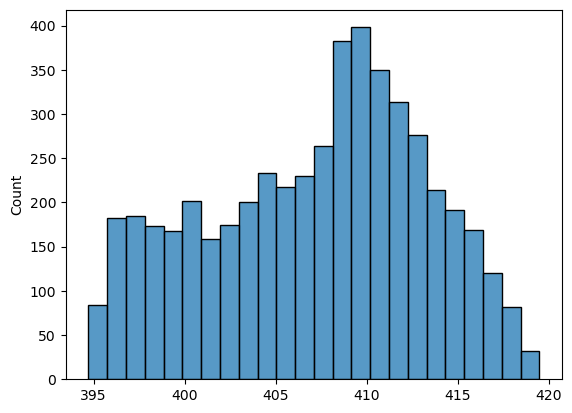

In [73]:
seaborn.histplot(values)

4.594071683530313

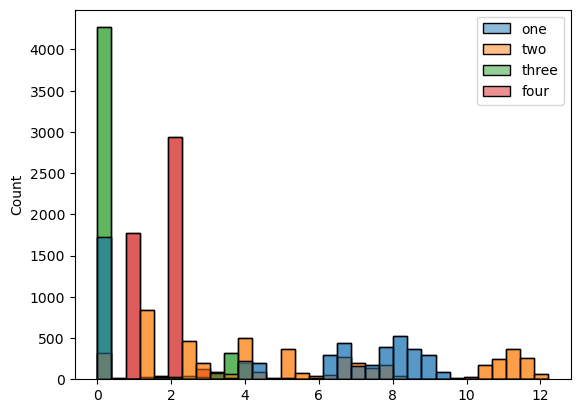

In [75]:
paramsdf = pandas.DataFrame(params, columns= ["one","two","three", "four"])
seaborn.histplot(paramsdf).get_figure().savefig("plot5, perfect information parameters for 5000 realisations")
seaborn.histplot(paramsdf)
max(paramsdf["three"])